### **Imports Made**:
- Numpy for general purpose tasks (ex: file loads, matrix operations and arrangements, etc)
- sklearn.linear_model for the multiple models tested
- sklearn.mixture for Gaussian Mixture Model
- data_spliter for splitting the data into training and testing sets
- matplotlib.pyplot for plotting the data

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [29]:
x = np.load("Xtrain_Classification1.npy")
y = np.load("ytrain_Classification1.npy")
x_project = np.load("Xtest_Classification1.npy")

database2_x = np.load("database2_x.npy")
database2_y = np.load("database2_y.npy")


In [30]:
X_train, X_test, y_train, y_test = train_test_split((x).astype('float32')/255.0, y, test_size=0.2, random_state=1)

smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

X_train_resampled = X_train_resampled.reshape(-1, 28, 28, 3)
X_test = X_test.reshape(-1, 28, 28, 3)

In [31]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


augmented_data = []
augmented_labels = []

for i in range(X_train_resampled.shape[0]):
    img = X_train_resampled[i]
    label = y_train_resampled[i]
    img = img.reshape((1,) + img.shape)  # Reshape the image for flow method
    label = np.array([label])  # Convert label to numpy array
    for batch in datagen.flow(img, label, batch_size=1):
        augmented_data.append(batch[0][0])  # Extract augmented image
        augmented_labels.append(batch[1][0])  # Extract augmented label
        break  # Exit the loop after one iteration to avoid infinite loop

# Convert augmented data and labels to numpy arrays
augmented_data = np.array(augmented_data)
augmented_labels = np.array(augmented_labels)
augmented_data=np.round(augmented_data).astype(int)

In [32]:
augmented_labels = tf.keras.utils.to_categorical(augmented_labels,2)
y_train_resampled = tf.keras.utils.to_categorical(y_train_resampled,2)
y_test = tf.keras.utils.to_categorical(y_test,2)
database2_y = tf.keras.utils.to_categorical(database2_y,2)

In [33]:
X_train_resampled = np.concatenate([database2_x, X_train_resampled], axis=0)
y_train_resampled = np.concatenate([database2_y, y_train_resampled], axis=0)

final_x = np.concatenate((X_train_resampled, augmented_data), axis=0)
final_y = np.concatenate((y_train_resampled, augmented_labels), axis=0)

print(final_x.shape)
print(final_y.shape)

(8560, 28, 28, 3)
(1251, 28, 28, 3)
(8560, 28, 28, 3)
[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [1. 0.]]
(24938, 28, 28, 3)
(24938, 2)


In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), input_shape=(28, 28, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, kernel_size=(3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(2, activation="softmax")
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Extract accuracy values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')


#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=1e-2,
#    decay_steps=10000,
#    decay_rate=0.9)

#optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

#early_stopping = tf.keras.callbacks.EarlyStopping(
    #monitor='val_loss', patience=10, restore_best_weights=True)

NameError: name 'fsdfsdfs' is not defined

In [ ]:
y_predi = model.predict(X_test)

for i in y_predi:
    if i[0]>i[1]:
        i[0]=1
        i[1]=0
    else:
        i[0]=0
        i[1]=1
        
print(y_predi[:,0])

40/40 [==============================] - 1s 12ms/step
[1. 1. 0. ... 0. 1. 0.]


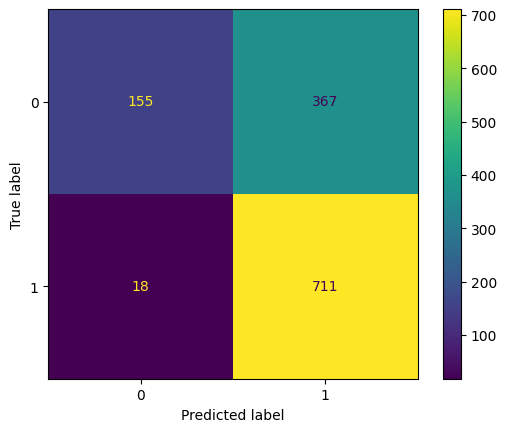

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(y_predi[:,0],y_test[:,0])
cm_display=ConfusionMatrixDisplay(cm).plot()